In [1]:
import numpy as np

import matplotlib.pyplot as plt

import warnings

from kneed import KneeLocator

from scipy.signal import argrelextrema
from scipy.interpolate import interp1d

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


# Generate some mock data

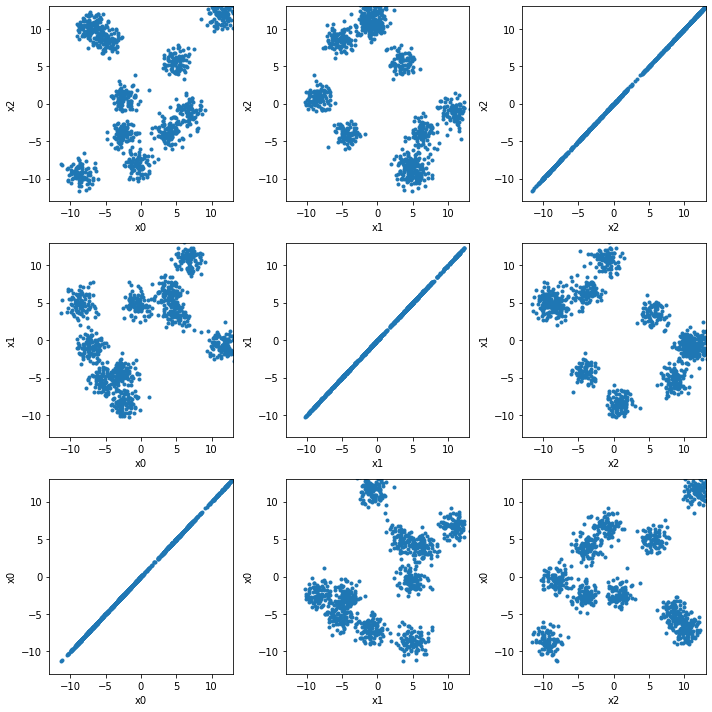

In [25]:
from pomegranate import *

ndim = 4
nclusters = 10

d = []
for i in range(nclusters):
    mean = np.random.uniform(-12, 12, size=ndim)
    cov = np.eye(ndim)
    d.append(MultivariateGaussianDistribution(mean, cov))
model = GeneralMixtureModel(d, weights=np.ones(nclusters)/nclusters)

pts = model.sample(1000)

fig1, axes = plt.subplots(nrows=ndim-1, ncols=ndim-1, figsize=(10, 10))
for col in np.arange(ndim-1):
    for row in np.arange(ndim-1):
        axes[ndim-row-2, col].scatter(pts[:,col], pts[:,row], 
                                      marker='.', c='C0')
        
        axes[ndim-row-2, col].set_xlabel("x"+str(col))
        axes[ndim-row-2, col].set_ylabel("x"+str(row))

        axes[ndim-row-2, col].set_xlim(-13, 13)
        axes[ndim-row-2, col].set_ylim(-13, 13)

plt.tight_layout()
plt.show()


# Clustering algorithm

In [41]:
def Standardize(X):
    """
    Standardize features - subtract mean and scale to unit variance
    
    INPUTS
    ------
    X: array, shape=(n,p)
        the positions of the n particles in the p-dimensional space
        
    RETURNS
    -------
    X_std: array, shape=(n,p)
        the positions of the n particles in the p-dimensional space
        standardised to zero-mean and unit-variance form
    """
    scaler = StandardScaler()
    scaler.fit(X)
    return scaler.transform(pts, copy=True)

def KMeans_clustering(X_std, K):
    """
    Apply the KMeans clustering algorithm
    
    INPUTS
    ------
    X_std: array, shape=(n,p)
        the positions of the n particles in the p-dimensional space
        standardised to zero-mean and unit-variance form
    K: int
        the number of clusters to use
    
    RETURNS
    -------
    I: float
        the inertia of the clustering; i.e. the sum of the squared
        distances between the points and the cluster centres
    membership: array, shape=(n,)
        for each particle, return an int in the range 0, K-1 
        identifying the cluster to which it belongs
    """
    kmeans = KMeans(n_clusters=K)
    c = kmeans.fit(X_std)
    
    I = c.inertia_
    memberships = kmeans.fit_predict(X_std) 
    
    return I, memberships


def NumberOfClusters(X_std, 
                     min_clusters, max_clusters, 
                     save_elbow_curve=None,
                     elbow_tol=1.0):
    """
    Find the optimum number of clusters in the data X_std
    
    This is an attempt to automate the "elbow method", but there
    is really no substitute for looking the plot using save_elbow_curve
    
    INPUTS
    ------
    X_std: array, shape=(n,p)
        the positions of the n particles in the p-dimensional space
        standardised to zero-mean and unit-variance form
    min_clusters, max_clusters: int
        if K is not provided then these instead give
        the range of the number of clusters to try
    save_elbow_curve: str
        if None, then do not produce the elbow curve plot, else
        this argument is the filname where plot is to be saved
    elbow_tol: float
        sensitivity parameter for elbow detection. "Put simply, 
        S is a measure of how many “flat” points we expect to see 
        in the unmodified data curve before declaring a knee"
        see https://raghavan.usc.edu//papers/kneedle-simplex11.pdf
        
    RETURNS
    -------
    K: int
        the number of clusters to use
    """
    # apply KMeans clustering for trial number of clusters in
    # the range (min_clusters, max_clusters) and record inertia
    nclusters = np.arange(min_clusters, max_clusters+1)
    distorsions = np.zeros_like(nclusters)
    for i, k in enumerate(nclusters):
        I, _ = KMeans_clustering(X_std, k)
        distorsions[i] = np.sqrt(I)

    # find the 'elbow' in the inertia curve
    knee_loc = KneeLocator(nclusters, distorsions, S=elbow_tol, 
                           curve="convex", direction="decreasing")
    if knee_loc.knee:
        K = knee_loc.knee
    else:
        warning.warn("Can't determine Nclusters; using min value K={}".format(min_clusters))
        K = min_clusters
    
    # make summary 'elbow' plot for visual inspection
    if save_elbow_curve is not None: # 
        plt.plot(nclusters, distorsions, 'b-+')
        plt.axvline(K, c='k', ls=':', label='K')
        plt.xticks(nclusters)
        plt.xlabel('Number of clusters')
        plt.ylabel('Sqrt(Inertia)')
        plt.title('Elbow Curve')
        plt.legend()
        plt.savefig(save_elbow_curve)
        plt.clf()
        
    return K

def Clustering(X, 
               K=None,
               min_clusters=1, max_clusters=20,
               save_elbow_curve=None,
               elbow_tol=1.0):
    """
    Function for using KMeans clustering to split up our swarms
    
    The number of clusters can be detected automatically using the 
    "elbow method" by specifying a search range (min/max_clusters)
    and a tolerance parameter (elbow_tol)
    
    INPUTS
    ------
    X: array, shape=(n,p)
        the positions of the n particles in the p-dimensional space
    K: int
        the number of clusters to use, if known in advance
    min_clusters, max_clusters: int
        if K is not provided then these instead give
        the range of the number of clusters to try
    save_elbow_curve: str
        if None, then do not produce the elbow curve plot, else
        this argument is the filname where plot is to be saved
    elbow_tol: float
        sensitivity parameter for elbow detection. "Put simply, 
        S is a measure of how many “flat” points we expect to see 
        in the unmodified data curve before declaring a knee"
        see https://raghavan.usc.edu//papers/kneedle-simplex11.pdf
        
    RETURNS
    -------
    result: dict with the following keys
        num_clusters: int 
            the number of clusters used by KMeans
        cluster_membership: array, shape=(n,)
            for each particle, return an int identifying the cluster
            to which it belongs
    """
    # check input has the correct shape
    assert X.ndim==2, "X.shape={} is not of form (n,p)".format(X.shape)

    # standardize the data to zero mean and unit variance
    X_std = Standardize(X)
    
    if K is None:
        # determine the number of clusters to use
        K = NumberOfClusters(X_std, min_clusters, max_clusters, 
                             save_elbow_curve=save_elbow_curve,
                             elbow_tol=elbow_tol)

    # run KMeans clustering on the data
    _, memberships = KMeans_clustering(X_std, K)
    
    return {'num_clusters': K, 'cluster_membership':memberships}


<Figure size 432x288 with 0 Axes>

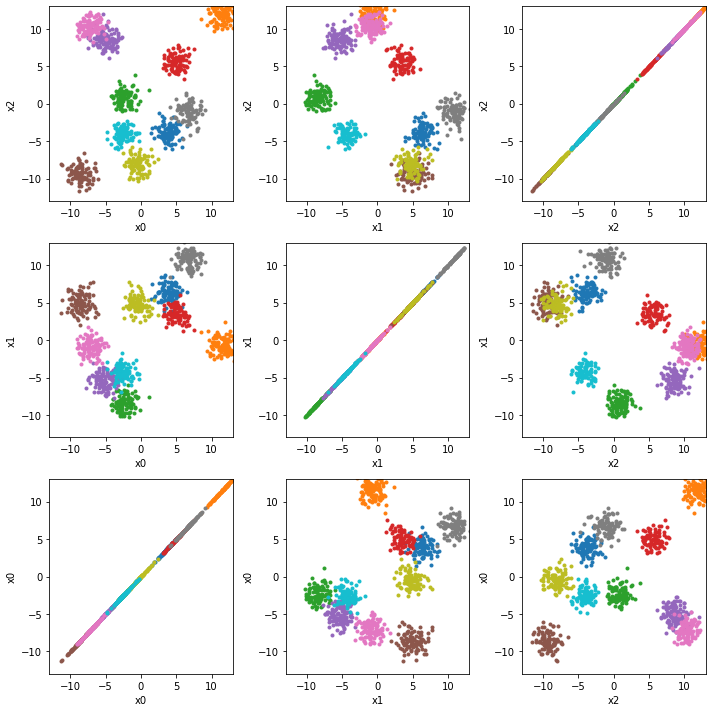

cluster detected = 10 of 10


In [42]:
C = Clustering(pts, save_elbow_curve='elbow.png', elbow_tol=1)

K = C['num_clusters']
m = C['cluster_membership']

fig1, axes = plt.subplots(nrows=ndim-1, ncols=ndim-1, figsize=(10, 10))
for col in np.arange(ndim-1):
    for row in np.arange(ndim-1):
        
        for k in range(K):
            mask = (m==k)
            axes[ndim-row-2, col].scatter(pts[mask][:,col], pts[mask][:,row], 
                                          marker='.', c='C'+str(k))
        
        axes[ndim-row-2, col].set_xlabel("x"+str(col))
        axes[ndim-row-2, col].set_ylabel("x"+str(row))

        axes[ndim-row-2, col].set_xlim(-13, 13)
        axes[ndim-row-2, col].set_ylim(-13, 13)

plt.tight_layout()
plt.show()

print("cluster detected =", K, "of", nclusters)
